In [ ]:
# Geometry-Guided Quantum SAT Solver
# Copyright (c) 2025, Sabarikirishwaran Ponnambalam
#
# This software is licensed under the Polyform Noncommercial License.
# See the LICENSE file in the project root for full license terms.

!pip install --no-cache-dir torch torchvision torchaudio -q
!pip install --no-cache-dir custatevec-cu12 cudaq -q
!pip install --no-cache-dir pandas numpy matplotlib geoopt -q
# !pip install --no-cache-dir pytorch-lightning -q
# !pip install --no-cache-dir lightning pennylane-lightning-gpu -q
# !pip install --no-cache-dir "jax[cuda12]" pennylane-catalyst -q

## Full state simulation for small scale

In [ ]:
# Geometry-Guided Quantum SAT Solver

import math
import itertools

import torch
import numpy as np
from tqdm import tqdm

import geoopt
from typing import List, Tuple
import matplotlib.pyplot as plt


# Clause type
Clause = List[Tuple[int, bool]]
Formula = List[Clause]

def generate_random_3sat(n_vars: int, n_clauses: int) -> Formula:
    formula = []
    for _ in range(n_clauses):
        clause_vars = np.random.choice(n_vars, 3, replace=False)
        clause = [(int(v), bool(np.random.randint(2))) for v in clause_vars]
        formula.append(clause)
    return formula

def eval_clause(bits: Tuple[int], clause: Clause) -> bool:
    return any((bits[v] ^ is_neg) for v, is_neg in clause)

def basis_states(n: int) -> List[Tuple[int]]:
    return list(itertools.product([0, 1], repeat=n))

# Clause projector
def clause_projector(n: int, clause: Clause) -> torch.Tensor:
    dim = 2 ** n
    P = torch.zeros((dim, dim), dtype=torch.cdouble)
    for i, bits in enumerate(basis_states(n)):
        if eval_clause(bits, clause):
            P[i, i] = 1.0
    return P

def full_solution_projector(n: int, formula: Formula) -> torch.Tensor:
    dim = 2 ** n
    P = torch.zeros((dim, dim), dtype=torch.cdouble)
    for i, bits in enumerate(basis_states(n)):
        if all(eval_clause(bits, c) for c in formula):
            P[i, i] = 1.0
    return P

def fubini_study_angle(psi: torch.Tensor, phi: torch.Tensor) -> float:
    overlap = torch.abs(torch.vdot(psi, phi))
    return float(torch.acos(torch.clamp(overlap, 0.0, 1.0)))

# Geometry-guided unitary optimization on St(d,d)
def optimize_unitary_stiefel(psi: torch.Tensor, P: torch.Tensor, 
                              lr=0.1, steps=100) -> Tuple[torch.Tensor, List[float]]:
    d = psi.shape[0]
    manifold = geoopt.manifolds.Stiefel()
    U = geoopt.ManifoldParameter(torch.eye(d, dtype=torch.cdouble), manifold=manifold)
    optimizer = torch.optim.SGD([U], lr=lr)
    overlaps = []

    for _ in range(steps):
        optimizer.zero_grad()
        UHU = U.conj().T @ P @ U
        overlap = torch.vdot(psi, UHU @ psi).real
        loss = -overlap
        loss.backward()
        optimizer.step()
        overlaps.append(overlap.item())

    return U.detach(), overlaps

# Measurement & projection
def project_and_normalize(psi: torch.Tensor, P: torch.Tensor) -> Tuple[torch.Tensor, float]:
    p = torch.vdot(psi, P @ psi).real.item()
    if p < 1e-12:
        return psi, 0.0
    psi_proj = P @ psi / torch.sqrt(torch.tensor(p, dtype=torch.float64))
    return psi_proj, p

# Solver
def geometry_guided_solver(n: int, formula: Formula, steps=50, lr=0.1, verbose=False):
    dim = 2 ** n
    psi = torch.ones(dim, dtype=torch.cdouble) / math.sqrt(dim)
    projectors = [clause_projector(n, c) for c in formula]
    P_solution = full_solution_projector(n, formula)

    total_p = 1.0
    fs_angles = []

    for P in tqdm(projectors):
        U, _ = optimize_unitary_stiefel(psi, P, lr=lr, steps=steps)
        psi_rot = U @ psi
        psi, p_clause = project_and_normalize(psi_rot, P)
        total_p *= p_clause
        fs_angle = fubini_study_angle(psi, (P_solution @ psi) / torch.linalg.norm(P_solution @ psi))
        fs_angles.append(fs_angle)
        if verbose:
            print(f"Clause success: {p_clause:.6f}, Fubini–Study angle: {fs_angle:.4f} rad")
        if p_clause < 1e-6:
            break

    return {
        "final_state": psi,
        "success_prob": total_p,
        "fubini_angles": fs_angles,
        "overlap_solution": torch.vdot(psi, P_solution @ psi).real.item()
    }

# Time-to-solution
def time_to_solution(p_success: float, t_run: float, p_target=0.99) -> float:
    if p_success <= 0.0:
        return float("inf")
    if p_success >= 1.0:
        return t_run
    num_runs = math.log(1 - p_target) / math.log(1 - p_success)
    return t_run * num_runs

# Baselines (nonguided + classical)
def nonguided_measurement_solver(n: int, formula: Formula):
    dim = 2 ** n
    psi = torch.ones(dim, dtype=torch.cdouble) / math.sqrt(dim)
    total_p = 1.0
    for clause in formula:
        P = clause_projector(n, clause)
        p_clause = torch.vdot(psi, P @ psi).real.item()
        psi, _ = project_and_normalize(psi, P)
        total_p *= p_clause
    return total_p

# Benchmarking setup
def benchmark_experiment(n: int, m: int, trials=10):
    geo_scores = []
    nonguided_scores = []
    fs_logs = []
    for _ in range(trials):
        formula = generate_random_3sat(n, m)
        res = geometry_guided_solver(n, formula, steps=30, lr=0.1)
        geo_scores.append(res["success_prob"])
        fs_logs.append(res["fubini_angles"])
        nonguided = nonguided_measurement_solver(n, formula)
        nonguided_scores.append(nonguided)

    print("Geometry-guided avg success:", np.mean(geo_scores))
    print("Non-guided baseline avg success:", np.mean(nonguided_scores))
    return geo_scores, nonguided_scores, fs_logs

if __name__ == "__main__":
    n = 12
    m = 6
    geo_scores, nonguided_scores, fs_logs = benchmark_experiment(n, m, trials=5)

    plt.figure(figsize=(8, 4))
    for angles in fs_logs:
        plt.plot(angles, label='Fubini–Study angle')
    plt.xlabel("Clause step")
    plt.ylabel("Fubini–Study angle (rad)")
    plt.title("Geometric evolution of state vs solution space")
    plt.grid()
    plt.show()

## Quantum Parametric Circuit

In [1]:
"""
Geometry-guided 3-SAT solver (flag-projector version) with CUDA-Q (cuQuantum backend)
and Riemannian optimization over a parametric circuit's angles (theta) and
flag-projector weights (alpha).

Key design points (matches our verbal spec):

- 3-SAT clauses -> commuting local projectors P_C^sat, P_C^unsat built from Pauli Z operators.
- SAT Hamiltonian:   H_unsat = sum_C P_C^unsat,    <H_unsat>/m = fraction of unsatisfied clauses.
- Prefix flag projectors:
      P_prefix^(k) = Π_{j=1}^k P_Cj^sat
  built algebraically as products of commuting projectors.
- Global "flag" projector ansatz:
      M_α = Σ_{k=1}^m α_k P_prefix^(k)
  with α_k ≥ 0, Σ α_k = 1 via softmax(β).

- Loss:
      L(θ, β) = (1/m) <H_unsat>_θ + λ_flag * (1 - <M_α>_θ)
              = <H_eff(α)>_θ + λ_flag,
    where H_eff(α) = (1/m) H_unsat - λ_flag Σ_k α_k P_prefix^(k).

- Gradients:
  * ∂L/∂θ:   via CUDA-Q ParameterShift gradients on H_eff(α).
  * ∂L/∂β:   analytic via chain rule through α = softmax(β),
             with ∂L/∂α_k = -λ_flag <P_prefix^(k)>_θ.

- Optimization:
  * θ, β treated as geoopt.ManifoldParameter on Euclidean manifolds.
  * Updated jointly via geoopt.optim.RiemannianAdam.

- No precompute_sat_data, no 2^n classical arrays, no sampling-based estimation.
"""

import math
import time
from typing import List, Tuple, Dict, Any

import numpy as np
import torch
import geoopt

import cudaq
from cudaq import spin
from tqdm.auto import tqdm

# --------------------------------------------------------------------
# SAT encoding
# --------------------------------------------------------------------

Clause = List[Tuple[int, bool]]  # (var_index, is_negated)
Formula = List[Clause]


def generate_random_3sat(n_vars: int, n_clauses: int) -> Formula:
    """
    Random 3-SAT instance with distinct vars per clause.
    clause literal: (var_index, is_negated)
        is_negated == False -> literal is x_i
        is_negated == True  -> literal is ¬x_i
    """
    formula: Formula = []
    for _ in range(n_clauses):
        clause_vars = np.random.choice(n_vars, 3, replace=False)
        clause: Clause = [(int(v), bool(np.random.randint(2))) for v in clause_vars]
        formula.append(clause)
    return formula


# --------------------------------------------------------------------
# Clause projectors as local Pauli operators
# --------------------------------------------------------------------

def clause_unsat_spin(clause: Clause):
    """
    Build the projector onto the unique UNSAT assignment of a 3-SAT clause
    as a spin operator in Z-basis.

    Clause C = (l1 ∨ l2 ∨ l3), each literal l_j is x or ¬x.

    Unsatisfied iff all literals are FALSE:
      - If literal is x_i: false when x_i = 0  -> |0> (Z=+1)
      - If literal is ¬x_i: false when x_i = 1 -> |1> (Z=-1)

    For a single qubit j, projector onto |b> (b∈{0,1}) is:
      P_b(j) = (I + (-1)^b Z_j)/2

    For three qubits (i, j, k) with bits b_i, b_j, b_k, the joint projector is:
      P_b = Π_{q in {i,j,k}} P_{b_q}(q)
          = (1/8) * [ I
                     + s_i Z_i + s_j Z_j + s_k Z_k
                     + s_i s_j Z_i Z_j + s_i s_k Z_i Z_k + s_j s_k Z_j Z_k
                     + s_i s_j s_k Z_i Z_j Z_k ],
      where s_q = (-1)^{b_q}.

    We return P_C^unsat, a cudaq.spin_op-like object.
    """
    if len(clause) != 3:
        raise ValueError("This helper assumes exactly 3 literals per clause.")

    # Extract qubit indices and bit-pattern for the unsatisfied assignment.
    # b_q = 0 if literal is x_q (unsat when x_q=0),
    # b_q = 1 if literal is ¬x_q (unsat when x_q=1).
    qubits = []
    s_vals = []
    for var_idx, is_neg in clause:
        qubits.append(var_idx)
        b_q = 0 if not is_neg else 1
        s_vals.append(1.0 if b_q == 0 else -1.0)

    i, j, k = qubits
    s1, s2, s3 = s_vals

    # Start from scalar 1.0 (identity term).
    op = 1.0
    # Single-Z terms
    op += s1 * spin.z(i)
    op += s2 * spin.z(j)
    op += s3 * spin.z(k)
    # Two-body terms
    op += s1 * s2 * spin.z(i) * spin.z(j)
    op += s1 * s3 * spin.z(i) * spin.z(k)
    op += s2 * s3 * spin.z(j) * spin.z(k)
    # Three-body term
    op += s1 * s2 * s3 * spin.z(i) * spin.z(j) * spin.z(k)

    # Overall factor 1/8
    op *= 0.125
    return op  # this is P_C^unsat


def build_clause_and_flag_operators(formula: Formula):
    """
    From a formula (ordered list of clauses), build:

      - H_unsat = sum_C P_C^unsat
      - clause_unsat_ops: [P_C1^unsat, P_C2^unsat, ...]
      - prefix_ops: [P_prefix^(1), P_prefix^(2), ..., P_prefix^(m)]

    where:
      P_Cj^sat = I - P_Cj^unsat
      P_prefix^(k) = Π_{j=1}^k P_Cj^sat

    All operators are diagonal in Z basis and commute by construction.
    """
    if not formula:
        raise ValueError("Formula must contain at least one clause.")

    m = len(formula)

    # Use the first clause's first var index to create a "zero" spin operator.
    first_qubit = formula[0][0][0]
    H_unsat = 0.0 * spin.i(first_qubit)  # zero operator with correct type

    clause_unsat_ops = []
    clause_sat_ops = []

    for clause in formula:
        P_unsat_C = clause_unsat_spin(clause)
        clause_unsat_ops.append(P_unsat_C)
        P_sat_C = 1.0 - P_unsat_C   # P_C^sat = I - P_C^unsat
        clause_sat_ops.append(P_sat_C)
        H_unsat = H_unsat + P_unsat_C

    # Build prefix projectors P_prefix^(k)
    prefix_ops = []
    prefix = None
    for P_sat_C in clause_sat_ops:
        if prefix is None:
            prefix = P_sat_C
        else:
            # Product of commuting projectors
            prefix = prefix * P_sat_C
        prefix_ops.append(prefix)

    assert len(prefix_ops) == m
    return H_unsat, clause_unsat_ops, prefix_ops


# --------------------------------------------------------------------
# CUDA-Q parametric ansatz
# --------------------------------------------------------------------

@cudaq.kernel
def sat_ansatz(params: list[float], n_qubits: int):
    """
    Simple parametric ansatz:
      - Start in |0..0>
      - Apply H on each qubit -> |+>^n
      - depth layers of (RY, RZ) per qubit + CNOT chain entanglers

    params length must be 2 * n_qubits * depth.
    """
    q = cudaq.qvector(n_qubits)

    # Reference state |+>^n
    for i in range(n_qubits):
        h(q[i])

    depth = int(len(params) // (2 * n_qubits))
    idx = 0
    for _ in range(depth):
        # Single-qubit rotations
        for i in range(n_qubits):
            ry(params[idx], q[i])
            idx += 1
            rz(params[idx], q[i])
            idx += 1
        # Entangling layer: nearest-neighbor CNOT chain
        for i in range(n_qubits - 1):
            x.ctrl(q[i], q[i + 1])


def set_cudaq_target():
    """
    Try GPU / cuQuantum backends first; fall back to default.
    """
    for target in ["nvidia", "cuquantum", "qpp"]:
        try:
            cudaq.set_target(target)
            print(f"[CUDA-Q] Using target: {target}")
            return
        except Exception:
            continue
    print("[CUDA-Q] Using default target.")


# --------------------------------------------------------------------
# Loss, metrics, gradients
# --------------------------------------------------------------------

def softmax(beta: np.ndarray) -> np.ndarray:
    """Stable softmax to map unconstrained beta -> α on simplex."""
    b_max = beta.max()
    exp_b = np.exp(beta - b_max)
    return exp_b / exp_b.sum()


def evaluate_metrics(
    theta: np.ndarray,
    n_qubits: int,
    H_unsat,
    prefix_ops,
    alpha: np.ndarray,
) -> Dict[str, Any]:
    """
    Evaluate metrics (no gradients):

      - frac_unsat = <H_unsat>/m
      - sat_prob   = 1 - frac_unsat
      - prefix_expectations: [<P_prefix^(1)>, ..., <P_prefix^(m)>]
      - M_expect = <M_α> = Σ_k α_k <P_prefix^(k)>
      - loss = frac_unsat + λ_flag*(1 - M_expect) is *not* computed here
              (we use an equivalent H_eff-based loss for gradients).
    """
    m = len(prefix_ops)
    theta_list = theta.tolist()

    # Expectation of H_unsat
    res_unsat = cudaq.observe(sat_ansatz, H_unsat, theta_list, n_qubits)
    E_unsat = res_unsat.expectation()
    frac_unsat = E_unsat / m
    sat_prob = 1.0 - frac_unsat

    # Prefix expectations
    prefix_expectations = []
    for Pk in prefix_ops:
        res_k = cudaq.observe(sat_ansatz, Pk, theta_list, n_qubits)
        prefix_expectations.append(res_k.expectation())
    prefix_expectations = np.array(prefix_expectations, dtype=float)

    # Global flag projector expectation
    M_expect = float(np.dot(alpha, prefix_expectations))

    return {
        "E_unsat": float(E_unsat),
        "frac_unsat": float(frac_unsat),
        "sat_prob": float(sat_prob),
        "prefix_expectations": prefix_expectations,
        "M_expect": M_expect,
    }


def build_effective_hamiltonian(
    H_unsat,
    prefix_ops,
    alpha: np.ndarray,
    lambda_flag: float,
) :
    """
    Build the effective Hamiltonian:

        H_eff(α) = (1/m) H_unsat - λ_flag * Σ_k α_k P_prefix^(k)

    s.t.  L(θ,α) = <H_eff>_θ + λ_flag.
    """
    m = len(prefix_ops)
    H_eff = (1.0 / m) * H_unsat
    for k, Pk in enumerate(prefix_ops):
        H_eff = H_eff - lambda_flag * alpha[k] * Pk
    return H_eff

def compute_theta_gradient_parameter_shift(
    theta: np.ndarray,
    n_qubits: int,
    H_eff,
) -> Tuple[float, np.ndarray]:
    """
    Use CUDA-Q ParameterShift gradients on:

        f(θ) = <H_eff>_θ = observe(ansatz, H_eff, θ).expectation()
    """
    theta_list = theta.tolist()

    def get_expectation(param_list: list[float]) -> float:
        res = cudaq.observe(sat_ansatz, H_eff, param_list, n_qubits)
        return res.expectation()

    grad_strategy = cudaq.gradients.ParameterShift()
    cost_theta = get_expectation(theta_list)
    grad_list = grad_strategy.compute(theta_list, get_expectation, cost_theta)
    grad_theta = np.array(grad_list, dtype=np.float64)
    return float(cost_theta), grad_theta



def compute_beta_gradient_from_prefix(
    alpha: np.ndarray,
    prefix_expectations: np.ndarray,
    lambda_flag: float,
) -> np.ndarray:
    """
    Given α = softmax(β) and prefix expectations p_k = <P_prefix^(k)>,

      L(θ, β) = ... + λ_flag*(1 - Σ_k α_k p_k)

    Then:

      ∂L/∂α_k = -λ_flag * p_k

    and α = softmax(β) => ∂α/∂β = diag(α) - α α^T.

    So:

      ∂L/∂β = (diag(α) - α α^T) @ (∂L/∂α)

            = diag(α) g_α - α (α^T g_α),

    where g_α_k = ∂L/∂α_k.
    """
    g_alpha = -lambda_flag * prefix_expectations  # shape (m,)
    s = float(np.dot(alpha, g_alpha))            # scalar
    g_beta = alpha * g_alpha - alpha * s         # elementwise
    return g_beta


# --------------------------------------------------------------------
# Main optimization loop
# --------------------------------------------------------------------

def optimize_geometry_guided_sat(
    n: int,
    formula: Formula,
    depth: int = 1,
    max_iters: int = 20,
    lr: float = 0.1,
    lambda_flag: float = 0.5,
    verbose: bool = True,
) -> Tuple[np.ndarray, np.ndarray, List[Dict[str, Any]], float]:
    """
    Jointly optimize (θ, β) for the geometry-guided SAT solver:

      - θ: circuit angles for sat_ansatz.
      - β: unconstrained parameters; α = softmax(β) are flag-projector weights.

    Loss:
      L(θ, β) = <H_eff(α)>_θ + λ_flag
              = (1/m)<H_unsat>_θ + λ_flag*(1 - <M_α>_θ)

    Returns:
      best_theta  (numpy array)
      best_beta   (numpy array)  # from which α = softmax(best_beta)
      history     (list of metric dicts over iterations)
      total_time  (seconds)
    """
    set_cudaq_target()

    # Build clause-level and flag-level operators from Pauli Z's.
    H_unsat, clause_unsat_ops, prefix_ops = build_clause_and_flag_operators(formula)
    m = len(prefix_ops)

    # Parameter dimensions
    num_params = 2 * n * depth

    # geoopt parameters on Euclidean manifold
    manifold = geoopt.manifolds.Euclidean()

    theta_t = geoopt.ManifoldParameter(
        torch.zeros(num_params, dtype=torch.float64), manifold=manifold
    )
    beta_t = geoopt.ManifoldParameter(
        torch.zeros(m, dtype=torch.float64), manifold=manifold
    )

    optimizer = geoopt.optim.RiemannianAdam([theta_t, beta_t], lr=lr)

    history: List[Dict[str, Any]] = []
    best_theta = None
    best_beta = None
    best_sat_prob = -1.0

    start_time = time.perf_counter()

    it_range = range(max_iters)
    if verbose:
        it_range = tqdm(it_range, desc="Geom-guided optimization", unit="iter")

    for it in it_range:
        optimizer.zero_grad(set_to_none=True)

        # Current parameters as numpy arrays
        theta = theta_t.detach().cpu().numpy().astype(np.float64)
        beta = beta_t.detach().cpu().numpy().astype(np.float64)
        alpha = softmax(beta)  # flag weights on simplex

        # Build H_eff(α) for this iteration
        H_eff = build_effective_hamiltonian(H_unsat, prefix_ops, alpha, lambda_flag)

        # 1) Quantum cost and gradient wrt θ via ParameterShift
        cost_theta, grad_theta = compute_theta_gradient_parameter_shift(
            theta, n_qubits=n, H_eff=H_eff
        )
        # Full loss includes +λ_flag (constant wrt θ, β)
        loss_value = cost_theta + lambda_flag

        # 2) Metrics with separate observe calls: <H_unsat>, <P_prefix^(k)>, <M_α>
        metrics = evaluate_metrics(theta, n_qubits=n, H_unsat=H_unsat,
                                   prefix_ops=prefix_ops, alpha=alpha)

        # 3) Gradient wrt β via α = softmax(β) and prefix expectations
        g_beta = compute_beta_gradient_from_prefix(
            alpha=alpha,
            prefix_expectations=metrics["prefix_expectations"],
            lambda_flag=lambda_flag,
        )

        # 4) Attach gradients to geoopt parameters
        theta_t.grad = torch.from_numpy(grad_theta).to(theta_t)
        beta_t.grad = torch.from_numpy(g_beta).to(beta_t)

        # 5) Step
        optimizer.step()

        # 6) Track best by "sat_prob" (1 - frac_unsat) or by M_expect if you prefer
        sat_prob = metrics["sat_prob"]
        if sat_prob > best_sat_prob:
            best_sat_prob = sat_prob
            best_theta = theta.copy()
            best_beta = beta.copy()

        # Log iteration metrics
        metrics_record = {
            "iter": it,
            "loss": float(loss_value),
            "cost_theta": float(cost_theta),
            "sat_prob": float(metrics["sat_prob"]),
            "frac_unsat": float(metrics["frac_unsat"]),
            "E_unsat": float(metrics["E_unsat"]),
            "M_expect": float(metrics["M_expect"]),
            "alpha": alpha.copy(),
            "prefix_expectations": metrics["prefix_expectations"].copy(),
            "theta_grad_norm": float(np.linalg.norm(grad_theta)),
            "beta_grad_norm": float(np.linalg.norm(g_beta)),
        }
        history.append(metrics_record)

        if verbose:
            postfix = {
                "L": f"{loss_value:.4f}",
                "sat": f"{sat_prob:.4f}",
                "Mα": f"{metrics['M_expect']:.4f}",
                "‖∇θ‖": f"{metrics_record['theta_grad_norm']:.3f}",
            }
            if isinstance(it_range, tqdm):
                it_range.set_postfix(postfix)

    total_time = time.perf_counter() - start_time
    return best_theta, best_beta, history, total_time


# --------------------------------------------------------------------
# Time-to-solution and inference
# --------------------------------------------------------------------

def time_to_solution(p_success: float, t_run: float, p_target: float = 0.99) -> float:
    """
    Expected time to achieve overall success probability >= p_target,
    assuming independent repeats with per-run success p_success and
    runtime t_run per run.
    """
    if p_success <= 0.0:
        return float("inf")
    if p_success >= 1.0:
        return t_run
    num_runs = math.log(1.0 - p_target) / math.log(1.0 - p_success)
    return t_run * num_runs


def run_inference_with_flag_projector(
    theta: np.ndarray,
    beta: np.ndarray,
    n: int,
    formula: Formula,
    p_target: float = 0.99,
) -> Dict[str, Any]:
    """
    "SATCIB-style" inference:

      - Rebuild clause and prefix projectors.
      - Use the full flag projector M_α with α = softmax(β).
      - Estimate:
          p_full = <P_prefix^(m)>_θ  (probability all clauses are satisfied)
          p_flag = <M_α>_θ           (flag alignment)
      - Estimate TTS using p_full and observed runtime per inference call.
    """
    H_unsat, clause_unsat_ops, prefix_ops = build_clause_and_flag_operators(formula)
    alpha = softmax(beta)
    theta_list = theta.tolist()

    # Probability that *all* clauses are satisfied:
    P_full = prefix_ops[-1]
    t0 = time.perf_counter()
    res_full = cudaq.observe(sat_ansatz, P_full, theta_list, n)
    t1 = time.perf_counter()
    p_full = res_full.expectation()
    t_run = t1 - t0

    # Optionally, also compute <M_α>_θ via prefix expectations
    prefix_expectations = []
    for Pk in prefix_ops:
        res_k = cudaq.observe(sat_ansatz, Pk, theta_list, n)
        prefix_expectations.append(res_k.expectation())
    prefix_expectations = np.array(prefix_expectations, dtype=float)
    M_expect = float(np.dot(alpha, prefix_expectations))

    tts = time_to_solution(p_success=p_full, t_run=t_run, p_target=p_target)

    return {
        "p_full_solution": float(p_full),
        "M_expect": M_expect,
        "t_run_single": float(t_run),
        "tts_est": float(tts),
        "alpha": alpha,
        "prefix_expectations": prefix_expectations,
    }


# --------------------------------------------------------------------
# Example driver
# --------------------------------------------------------------------
if __name__ == "__main__":
    # Example: moderate-size instance (adjust n, m, depth for your GPU / QPU)
    n = 10          # num variables / qubits
    m = 20          # num clauses
    depth = 2       # ansatz depth
    max_iters = 80  # optimization iterations

    formula = generate_random_3sat(n, m)
    print(f"Generated random 3-SAT with n={n}, m={m}")

    best_theta, best_beta, hist, total_time = optimize_geometry_guided_sat(
        n=n,
        formula=formula,
        depth=depth,
        max_iters=max_iters,
        lr=0.1,
        lambda_flag=0.5,
        verbose=True,
    )

    final_metrics = hist[-1]
    print("\n=== Training summary ===")
    print(f"Final sat_prob (1 - frac_unsat) ≈ {final_metrics['sat_prob']:.4f}")
    print(f"Final M_expect = <M_α> ≈ {final_metrics['M_expect']:.4f}")
    print(f"Total optimization wall time ≈ {total_time:.3f} s")

    # Inference + TTS
    inf_res = run_inference_with_flag_projector(
        theta=best_theta,
        beta=best_beta,
        n=n,
        formula=formula,
        p_target=0.99,
    )

    print("\n=== Inference / TTS ===")
    print(f"p_full_solution (all clauses satisfied) ≈ {inf_res['p_full_solution']:.4f}")
    print(f"<M_α> at inference ≈ {inf_res['M_expect']:.4f}")
    print(f"Single-run inference time ≈ {inf_res['t_run_single']:.6f} s")
    print(f"Estimated TTS (p_target=0.99) ≈ {inf_res['tts_est']:.3f} s")

Generated random 3-SAT with n=10, m=20
[CUDA-Q] Using target: nvidia


Geom-guided optimization:   0%|          | 0/80 [00:00<?, ?iter/s]


=== Training summary ===
Final sat_prob (1 - frac_unsat) ≈ 1.0000
Final M_expect = <M_α> ≈ 1.0000
Total optimization wall time ≈ 380.386 s

=== Inference / TTS ===
p_full_solution (all clauses satisfied) ≈ 0.9995
<M_α> at inference ≈ 1.0000
Single-run inference time ≈ 0.067205 s
Estimated TTS (p_target=0.99) ≈ 0.040 s


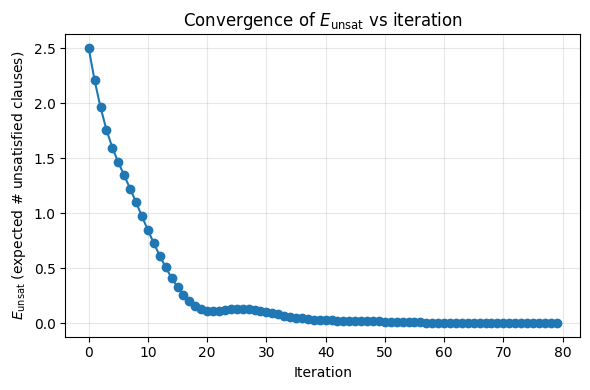

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data from history
iters = [entry["iter"] for entry in hist]
E_unsat = [entry["E_unsat"] for entry in hist]

plt.figure(figsize=(6, 4))
plt.plot(iters, E_unsat, marker="o")
plt.xlabel("Iteration")
plt.ylabel(r"$E_{\mathrm{unsat}}$ (expected # unsatisfied clauses)")
plt.title(r"Convergence of $E_{\mathrm{unsat}}$ vs iteration")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

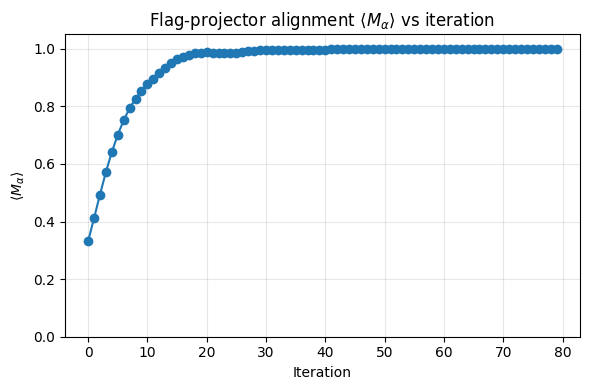

In [3]:
import numpy as np
import matplotlib.pyplot as plt

iters = [entry["iter"] for entry in hist]
M_expect = [entry["M_expect"] for entry in hist]

plt.figure(figsize=(6, 4))
plt.plot(iters, M_expect, marker="o")
plt.xlabel("Iteration")
plt.ylabel(r"$\langle M_{\alpha} \rangle$")
plt.title(r"Flag-projector alignment $\langle M_{\alpha} \rangle$ vs iteration")
plt.ylim(0.0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# If you stored FS angle to previous state as "theta_fs_prev"
# during training, this will work. Otherwise, this will raise
# a KeyError and you know you need to add logging in the loop.
fs_angles = []
iters = []

for entry in hist:
    if entry.get("theta_fs_prev") is not None:
        fs_angles.append(entry["theta_fs_prev"])
        iters.append(entry["iter"])

if len(fs_angles) == 0:
    raise ValueError(
        "No FS angles found in `hist`. "
        "Make sure you log them as 'theta_fs_prev' during training."
    )

plt.figure(figsize=(6, 4))
plt.plot(iters, fs_angles, marker="o")
plt.xlabel("Iteration")
plt.ylabel(r"Fubini–Study angle to reference (rad)")
plt.title("Fubini–Study angle vs iteration")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()